In [12]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

import seaborn as sns
import pandas as pd
import torch
import numpy as np
from src.interpretability import sample_from_hist, get_hist
import random

torch.manual_seed(4444)
np.random.seed(4444)
random.seed(4444)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def shapley_value(x, b, i, func, hist=None):
    from itertools import chain, combinations
    from math import factorial
    def powerset(iterable):
        "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
        s = list(iterable)
        return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

    n = len(x)
    l = list(range(n))
    del l[i]
    sv = 0

    if hist is not None:
        b = torch.tensor([sample_from_hist(hist[i]) for i in range(n)], dtype=torch.float32).flatten()

    for S in powerset(l):
        S = np.array(S).flatten()
        v1, v2 = b.clone(), b.clone()
        v1[i] = x[i]
        if len(S) != 0:
            v1[S] = x[S]
            v2[S] = x[S]
        const = factorial(len(S))*factorial(n-len(S)-1)/factorial(n)
        sv += const*(func(v1)-func(v2))
    return abs(sv)

In [14]:
def func():
    means = [1,2,3,4,1]
    # phi = np.concatenate([np.random.normal(loc=i, scale=0.1, size=(1,1)) for i in means], axis=1)
    # phi = torch.tensor(phi, dtype=torch.float32)
    phi = torch.tensor(means, dtype=torch.float32)
    def foo(x):
        return torch.sum(phi * x)
    return foo

def generate():
    locs = [1,1,1,1,8]
    x = np.concatenate([np.random.normal(loc=i, scale=1, size=(1,1)) for i in locs], axis=1)
    x = torch.tensor(x, dtype=torch.float32).flatten()
    return x

In [15]:
reps = 10
n = 10
m = generate().shape[0]

b = torch.tensor([0,0,0,0,0], dtype=torch.float32)
res = []
for _ in range(reps):
    aux2 = []
    f = func()
    x = torch.stack([generate() for _ in range(n)])
    hist_input = [get_hist(x[:,j], alpha=0) for j in range(m)]
    for j in range(n):
        # b = torch.mean(x, dim=0)
        aux = [shapley_value(x[j], b, i, f, hist=hist_input).item() for i in range(m)]
        aux2.append(aux)
    aux2 = np.mean(np.array(aux2), axis=0)
    res.append(aux2)
res = np.array(res)

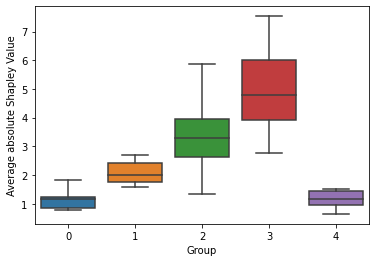

In [16]:
data = {"x": res.flatten(), "class": np.tile(range(m), reps)}
ax = sns.boxplot(x="class", y="x", data=data)
ax.set(xlabel="Group", ylabel="Average absolute Shapley Value")
ax.get_figure().savefig("base_zeros.png", dpi=100)